In [202]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
import matplotlib.ticker as mtick

In [203]:
# define model (create class to avoid long parameter passing lists)
class SinglePipeModel:
    p0: float = 1e6
    fluid_density: float = 1000
    height: float = 60
    pipe_length: float = 500
    pipe_area: float = 0.05
    gravity: float = 9.81
    drag_coefficient: float = 0.002
    flow_rate: float = 0
    power: float = 0
    
    min_flow_rate: float = 0
    max_flow_rate: float = 2
    
    min_power = 200_000
    max_power = 1_000_000
    
    # general model for different induced pressures
    def p_stat(self):
        return self.fluid_density * self.gravity * self.height
    
    def p_res(self):
        fluid_velocity = self.flow_rate / self.pipe_area
        return self.pipe_length * self.drag_coefficient * (self.fluid_density / 2) * fluid_velocity**2
    
    def p_pump(self):
        a = 4/27 * (self.p0**3)/((self.power-1e5)**2)
        b = self.p0 / 2
        return self.p0 - a * self.flow_rate**2 - b * self.flow_rate**3
    
    def differential_pressure(self):
        return self.p_stat() + self.p_res() - self.p_pump()
    
    def efficiency(self):
        return self.p_stat() * self.flow_rate / self.power
    
    
    # solver functions
    def update_flow_rate(self):    
        def root_function(x):
            self.flow_rate = x
            return self.differential_pressure()
        
        root = root_scalar(root_function, bracket=[self.min_flow_rate, self.max_flow_rate])
         
        if not root.converged:
            raise Exception("Flow rate did not converge")
         
        self.flow_rate = root.root        

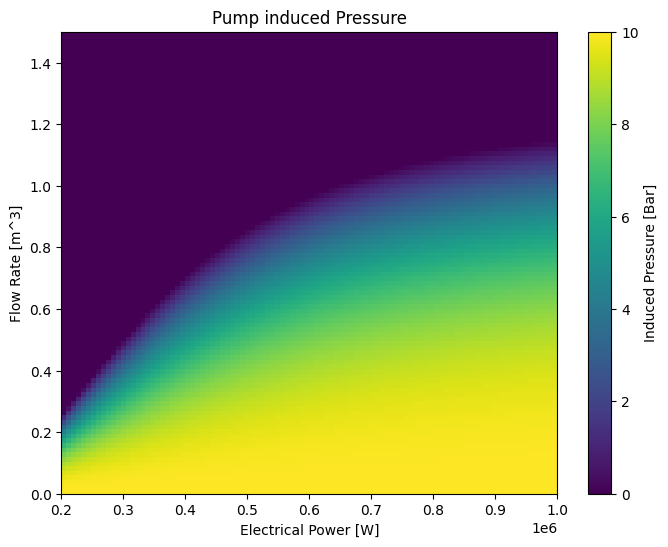

In [204]:
def plot_pump_characteristics():
    model = SinglePipeModel()
    
    powers = np.linspace(model.min_power, model.max_power, 100)
    flow_rates = np.linspace(0, 1.5, 100)
    pressures = np.zeros((len(flow_rates), len(powers)))
    
    # calculate pressure for different flow rate and power combinations
    for i, flow_rate in enumerate(flow_rates):
        for j, power in enumerate(powers):
            model.power = power
            model.flow_rate = flow_rate
            pressures[i, j] = model.p_pump()
    
    # clip values to zero
    pressures = np.clip(pressures, 0, None)
    
    # plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(pressures/100000, extent=(min(powers), max(powers), min(flow_rates), max(flow_rates)),
               aspect='auto', vmin=0, origin='lower')  # Set origin to 'lower'
    plt.colorbar(label='Induced Pressure [Bar]')
    plt.title("Pump induced Pressure")
    plt.xlabel("Electrical Power [W]")
    plt.ylabel("Flow Rate [m^3]")
    plt.show()
    
plot_pump_characteristics()

<Figure size 800x600 with 0 Axes>

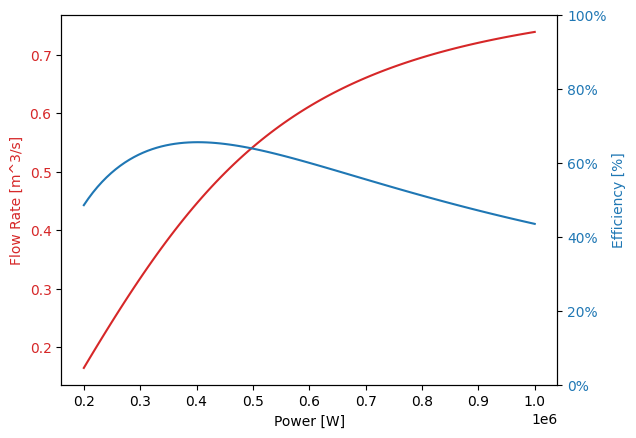

In [205]:
def plot_power_flow_rate_curve():
    model = SinglePipeModel()

    powers = np.linspace(model.min_power, model.max_power, 100)
    flow_rates = np.zeros_like(powers)
    efficiencies = np.zeros_like(powers)
    
    for i, power in enumerate(powers):
        model.power = power
        model.update_flow_rate()
        flow_rates[i] = model.flow_rate
        efficiencies[i] = model.efficiency()
        
    plt.figure(figsize=(8, 6))
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Power [W]')
    ax1.set_ylabel('Flow Rate [m^3/s]', color=color)
    ax1.plot(powers, flow_rates, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Efficiency [%]', color=color)
    ax2.plot(powers, efficiencies*100, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax2.set_ylim(0, 100)

    plt.show()
    
plot_power_flow_rate_curve()